# Causal Analysis Visualization
## Legacy System Problems - Causal Relationships Analysis

This notebook visualizes the results from the CESAR causal strength analysis, including:
- Top 10 highest confidence causal relationships
- Heatmap of causal strengths
- Interactive Hierarchical Edge Bundling network visualization

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Javascript
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from collections import defaultdict

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Load and Prepare Data

In [2]:
# Load the causal analysis cache file
cache_file = './tmp/causal_analysis_cache_CESAR_20250822_140932.json'

with open(cache_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Metadata: {data['metadata']}")
print(f"Total results: {len(data['results'])}")

# Convert results to DataFrame
results_list = []
for key, result in data['results'].items():
    results_list.append(result)

df = pd.DataFrame(results_list)
print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display basic statistics
print(f"\nConfidence statistics:")
print(df['confidence'].describe())

Metadata: {'start_time': '2025-08-22T14:09:32.006423', 'model': 'CESAR', 'cache_id': '20250822_140932', 'version': '1.0'}
Total results: 1026

DataFrame shape: (1026, 10)
Columns: ['pair', 'title_a', 'title_b', 'score_ab', 'score_ba', 'stronger_direction', 'confidence', 'stronger_score', 'timestamp', 'similarity']

Confidence statistics:
count    1026.000000
mean        0.154695
std         0.127682
min         0.000024
25%         0.054255
50%         0.124233
75%         0.223379
max         0.742011
Name: confidence, dtype: float64


## 2. Top 10 Highest Confidence Causal Relationships

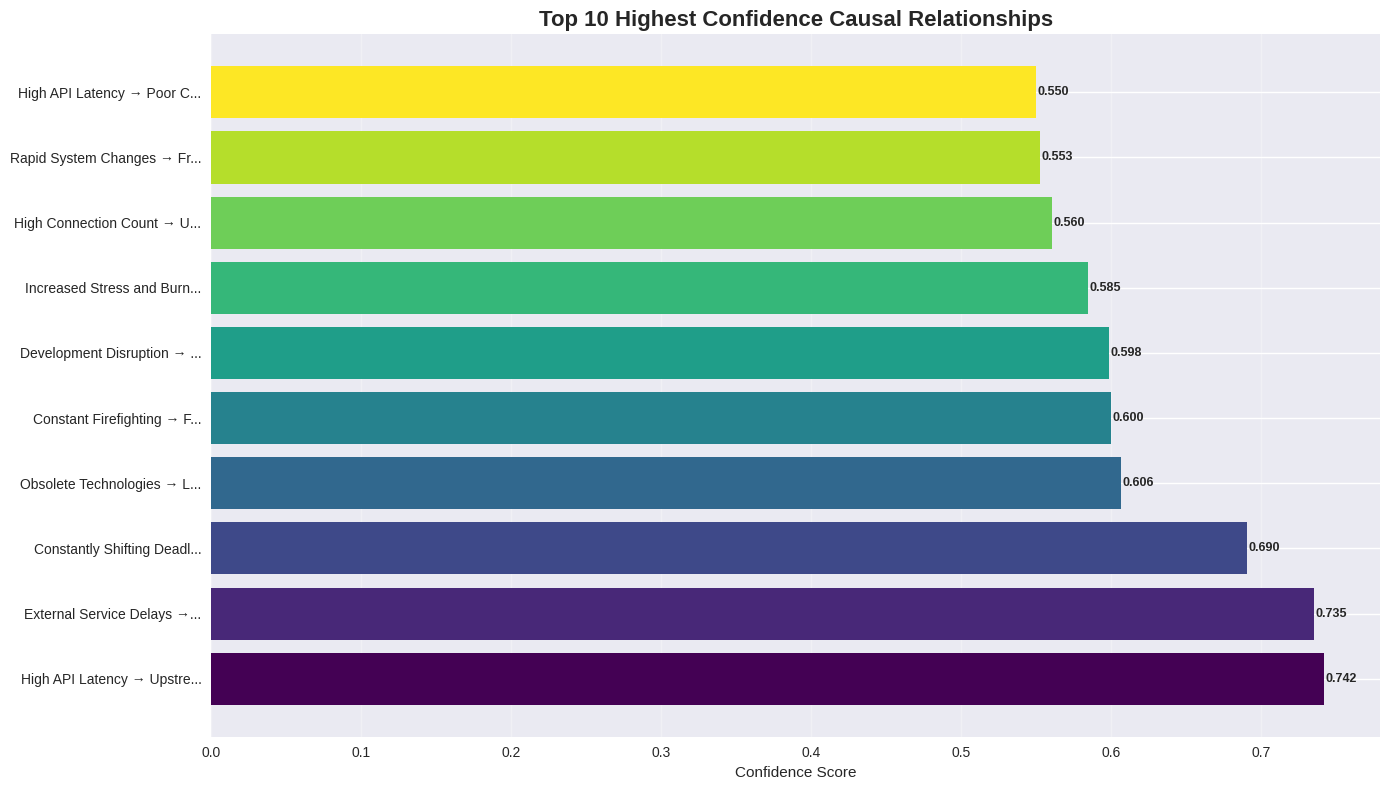


Top 10 Detailed Results:
                                              stronger_direction  confidence  stronger_score  score_ab  score_ba
                            High API Latency → Upstream Timeouts    0.742011        0.935366  0.935366  0.193355
                     External Service Delays → Upstream Timeouts    0.734857        0.928424  0.928424  0.193567
Constantly Shifting Deadlines → Frequent Changes to Requirements    0.690462        0.891800  0.891800  0.201338
                   Obsolete Technologies → Legacy Skill Shortage    0.606184        0.887721  0.281537  0.887721
        Constant Firefighting → Frequent Changes to Requirements    0.599818        0.819581  0.819581  0.219762
       Development Disruption → Frequent Changes to Requirements    0.598371        0.828683  0.828683  0.230311
Increased Stress and Burnout → Developer Frustration and Burnout    0.584743        0.807915  0.223172  0.807915
                       High Connection Count → Upstream Timeouts    0.

In [3]:
# Sort by confidence and get top 10
top_10 = df.nlargest(10, 'confidence')

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Truncate long titles for better display
def truncate_title(title, max_len=25):
    return title if len(title) <= max_len else title[:max_len] + "..."

labels = [truncate_title(row['stronger_direction']) for _, row in top_10.iterrows()]
confidences = top_10['confidence'].values

bars = ax.barh(range(len(labels)), confidences, color=plt.cm.viridis(np.linspace(0, 1, len(labels))))

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel('Confidence Score')
ax.set_title('Top 10 Highest Confidence Causal Relationships', fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add confidence values on bars
for i, (bar, conf) in enumerate(zip(bars, confidences)):
    ax.text(conf + 0.001, bar.get_y() + bar.get_height()/2, f'{conf:.3f}', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Display detailed table
print("\nTop 10 Detailed Results:")
display_cols = ['stronger_direction', 'confidence', 'stronger_score', 'score_ab', 'score_ba']
print(top_10[display_cols].to_string(index=False))

## 3. Causal Strength Heatmap

Total unique problems: 387


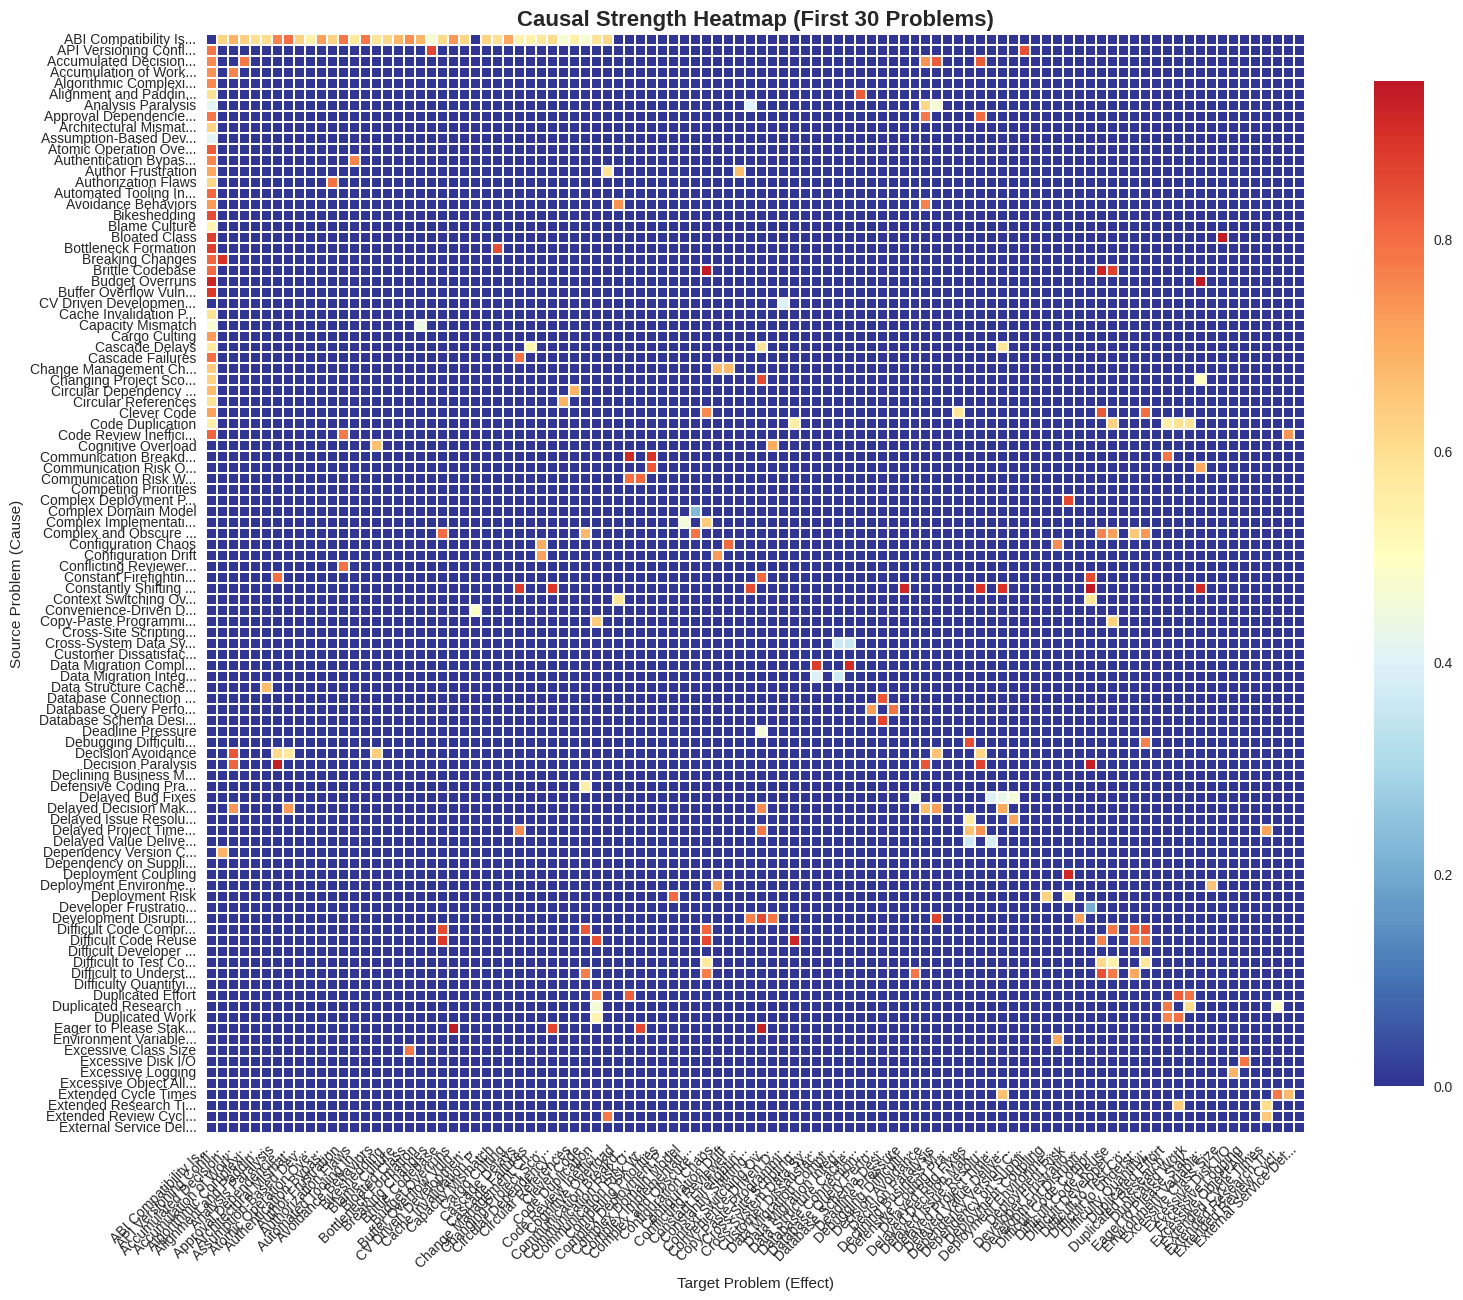

In [7]:
# Extract unique problem names
all_problems = set()
for _, row in df.iterrows():
    all_problems.add(row['title_a'])
    all_problems.add(row['title_b'])

problems_list = sorted(list(all_problems))
print(f"Total unique problems: {len(problems_list)}")

# Create causal strength matrix
n_problems = len(problems_list)
causal_matrix = np.zeros((n_problems, n_problems))
problem_to_idx = {prob: idx for idx, prob in enumerate(problems_list)}

for _, row in df.iterrows():
    idx_a = problem_to_idx[row['title_a']]
    idx_b = problem_to_idx[row['title_b']]
    
    # Fill both directions with their respective scores
    causal_matrix[idx_a, idx_b] = row['score_ab']
    causal_matrix[idx_b, idx_a] = row['score_ba']

# Create heatmap (showing subset for readability)
subset_size = 100 # len(problems_list) # min(30, len(problems_list))  # Show top 30 for readability
subset_problems = problems_list[:subset_size]
subset_matrix = causal_matrix[:subset_size, :subset_size]

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(subset_matrix, dtype=bool), k=1)  # Mask upper triangle to avoid duplication

sns.heatmap(subset_matrix, 
            xticklabels=[p[:20] + '...' if len(p) > 20 else p for p in subset_problems],
            yticklabels=[p[:20] + '...' if len(p) > 20 else p for p in subset_problems],
            annot=False, cmap='RdYlBu_r', center=0.5,
            square=True, linewidths=0.1, cbar_kws={"shrink": .8})

plt.title('Causal Strength Heatmap (First 30 Problems)', fontsize=16, fontweight='bold')
plt.xlabel('Target Problem (Effect)')
plt.ylabel('Source Problem (Cause)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Interactive Plotly Network Visualization

Using threshold: 0.249
High confidence relationships: 206
Network: 210 nodes, 206 edges


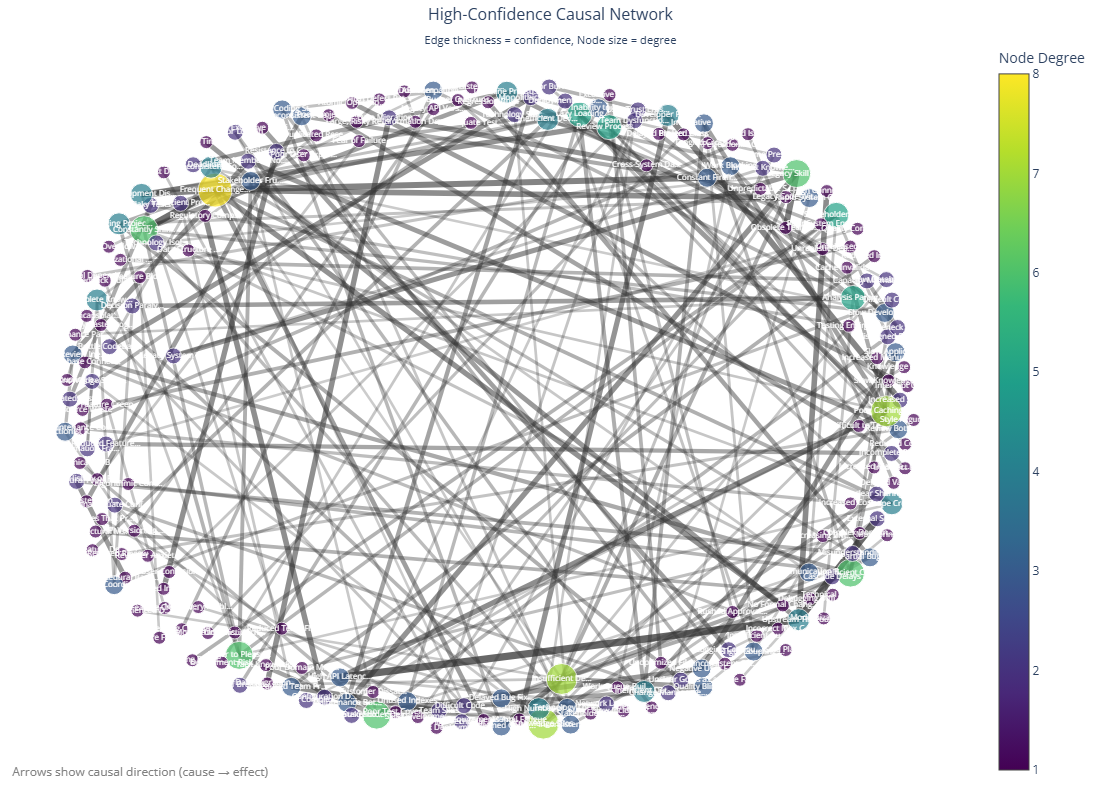

In [8]:
# Create network graph with high-confidence relationships
high_confidence_threshold = df['confidence'].quantile(0.8)  # Top 20%
high_conf_df = df[df['confidence'] >= high_confidence_threshold]

print(f"Using threshold: {high_confidence_threshold:.3f}")
print(f"High confidence relationships: {len(high_conf_df)}")

# Create network graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in high_conf_df.iterrows():
    # Determine source and target based on stronger direction
    if '→' in row['stronger_direction']:
        source, target = row['stronger_direction'].split(' → ')
        G.add_edge(source.strip(), target.strip(), 
                  confidence=row['confidence'],
                  stronger_score=row['stronger_score'])

print(f"Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Calculate layout
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Prepare data for plotly
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    text=[node[:15] + '...' if len(node) > 15 else node for node in G.nodes()],
    textposition="middle center",
    textfont=dict(size=8, color='white'),
    marker=dict(
        size=[G.degree(node) * 3 + 10 for node in G.nodes()],
        color=[G.degree(node) for node in G.nodes()],
        colorscale='Viridis',
        colorbar=dict(title="Node Degree"),
        line=dict(width=1, color='white')
    ),
    hovertemplate='<b>%{text}</b><br>Connections: %{marker.color}<extra></extra>',
    name='Problems'
)

# Create edges
edge_trace = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    confidence = edge[2]['confidence']
    
    edge_trace.append(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode='lines',
            line=dict(width=confidence * 10, color=f'rgba(50,50,50,{confidence})'),
            hoverinfo='none',
            showlegend=False
        )
    )

# Create the figure
fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(
                    title=dict(
                        text='High-Confidence Causal Network<br><sub>Edge thickness = confidence, Node size = degree</sub>',
                        x=0.5,
                        font=dict(size=16)
                    ),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[
                        dict(
                            text="Arrows show causal direction (cause → effect)",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002,
                            font=dict(size=12, color="gray")
                        )
                    ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    plot_bgcolor='white',
                    height=800
                ))

fig.show()

## 5. Hierarchical Edge Bundling with D3.js

In [9]:
# Prepare data for D3.js hierarchical edge bundling
# Group problems by category (first word or similar problems)
def get_category(problem_name):
    """Extract category from problem name"""
    # Simple categorization based on first word or common patterns
    name_lower = problem_name.lower()
    
    if any(word in name_lower for word in ['performance', 'slow', 'memory', 'cpu', 'latency']):
        return 'Performance'
    elif any(word in name_lower for word in ['security', 'vulnerability', 'authentication', 'authorization']):
        return 'Security'
    elif any(word in name_lower for word in ['team', 'communication', 'coordination', 'culture']):
        return 'Team'
    elif any(word in name_lower for word in ['code', 'programming', 'implementation', 'logic']):
        return 'Code'
    elif any(word in name_lower for word in ['test', 'quality', 'bug', 'defect']):
        return 'Quality'
    elif any(word in name_lower for word in ['deployment', 'release', 'environment', 'configuration']):
        return 'Operations'
    elif any(word in name_lower for word in ['database', 'data', 'query', 'schema']):
        return 'Data'
    elif any(word in name_lower for word in ['architecture', 'design', 'coupling', 'dependency']):
        return 'Architecture'
    elif any(word in name_lower for word in ['process', 'workflow', 'planning', 'management']):
        return 'Process'
    else:
        return 'Other'

# Create hierarchical structure
categories = defaultdict(list)
for node in G.nodes():
    category = get_category(node)
    categories[category].append(node)

print("Categories and counts:")
for cat, nodes in categories.items():
    print(f"  {cat}: {len(nodes)}")

# Prepare D3 data structure
d3_data = {
    "name": "Legacy System Problems",
    "children": []
}

for category, nodes in categories.items():
    category_node = {
        "name": category,
        "children": [{"name": node, "size": G.degree(node) + 1} for node in nodes]
    }
    d3_data["children"].append(category_node)

# Create edges data
edges_data = []
for source, target, data in G.edges(data=True):
    edges_data.append({
        "source": source,
        "target": target,
        "confidence": data['confidence']
    })

print(f"\nPrepared {len(edges_data)} edges for D3 visualization")

Categories and counts:
  Other: 130
  Process: 4
  Performance: 8
  Team: 11
  Data: 8
  Code: 14
  Quality: 17
  Architecture: 8
  Operations: 10

Prepared 206 edges for D3 visualization


In [13]:
# D3.js Hierarchical Edge Bundling Visualization
html_content = f'''
<!DOCTYPE html>
<html>
<head>
    <script src="https://d3js.org/d3.v7.min.js"></script>
    <style>
        .node {{
            font: 10px sans-serif;
        }}
        .node--internal {{
            cursor: pointer;
        }}
        .node--leaf {{
            cursor: pointer;
            fill: #4CAF50;
        }}
        .link {{
            fill: none;
            stroke-opacity: 0.4;
            stroke-width: 1.5px;
        }}
        .link--source, .link--target {{
            stroke-opacity: 1;
            stroke-width: 2px;
        }}
        .link--source {{
            stroke: #d62728 !important;
        }}
        .link--target {{
            stroke: #2ca02c !important;
        }}
        .node--target {{
            fill: #2ca02c !important;
        }}
        .node--source {{
            fill: #d62728 !important;
        }}
        #chart {{
            width: 100%;
            height: 800px;
        }}
    </style>
</head>
<body>
    <div id="chart"></div>
    <div style="margin-top: 20px; font-family: Arial, sans-serif;">
        <p><strong>Instructions:</strong> Hover over any problem (leaf node) to see its causal connections.</p>
        <p><span style="color: #d62728;">●</span> Red: Outgoing causality (this problem causes others)</p>
        <p><span style="color: #2ca02c;">●</span> Green: Incoming causality (this problem is caused by others)</p>
    </div>

    <script>
        const data = {json.dumps(d3_data, indent=2)};
        const links = {json.dumps(edges_data, indent=2)};
        
        const width = 954;
        const height = 800;
        const radius = width / 2;

        const tree = d3.cluster().size([2 * Math.PI, radius - 100]);
        const root = tree(d3.hierarchy(data).sort((a, b) => d3.ascending(a.data.name, b.data.name)));

        const svg = d3.select("#chart").append("svg")
            .attr("width", width)
            .attr("height", height)
            .append("g")
            .attr("transform", `translate(${{width / 2}},${{height / 2}})`);

        const line = d3.lineRadial()
            .curve(d3.curveBundle.beta(0.85))
            .radius(d => d.y)
            .angle(d => d.x);

        // Create lookup for leaf nodes
        const nodeByName = new Map(root.leaves().map(d => [d.data.name, d]));

        // Create links between nodes
        const linkData = links.map(l => {{
            const source = nodeByName.get(l.source);
            const target = nodeByName.get(l.target);
            if (source && target) {{
                return {{
                    source: source,
                    target: target,
                    confidence: l.confidence
                }};
            }}
            return null;
        }}).filter(d => d !== null);

        // Draw links
        const link = svg.append("g")
            .attr("stroke", "#999")
            .attr("fill", "none")
            .selectAll("path")
            .data(linkData)
            .enter().append("path")
            .attr("class", "link")
            .attr("d", d => line(d.source.path(d.target)))
            .attr("stroke-opacity", d => d.confidence * 0.8)
            .attr("stroke-width", d => Math.max(1, d.confidence * 3));

        // Draw nodes
        const node = svg.append("g")
            .selectAll("g")
            .data(root.descendants())
            .enter().append("g")
            .attr("class", d => `node ${{d.children ? "node--internal" : "node--leaf"}}`)
            .attr("transform", d => `rotate(${{d.x * 180 / Math.PI - 90}}) translate(${{d.y}},0)`);

        node.append("circle")
            .attr("r", d => d.children ? 3 : 2.5)
            .attr("fill", d => d.children ? "#555" : "#4CAF50");

        node.append("text")
            .attr("dy", "0.31em")
            .attr("x", d => d.x < Math.PI === !d.children ? 6 : -6)
            .attr("text-anchor", d => d.x < Math.PI === !d.children ? "start" : "end")
            .attr("transform", d => d.x >= Math.PI ? "rotate(180)" : null)
            .text(d => d.data.name)
            .style("font-size", d => d.children ? "12px" : "10px")
            .style("font-weight", d => d.children ? "bold" : "normal");

        // Add interactivity
        node.filter(d => !d.children)
            .on("mouseover", mouseovered)
            .on("mouseout", mouseouted);

        function mouseovered(event, d) {{
            node.each(function(n) {{ n.target = n.source = false; }});

            link.classed("link--target", function(l) {{
                if (l.target === d) return l.source.source = true;
            }}).classed("link--source", function(l) {{
                if (l.source === d) return l.target.target = true;
            }}).filter(function(l) {{
                return l.target === d || l.source === d;
            }}).raise();

            node.classed("node--target", function(n) {{ return n.target; }})
                .classed("node--source", function(n) {{ return n.source; }});
        }}

        function mouseouted(event, d) {{
            link.classed("link--target", false)
                .classed("link--source", false);

            node.classed("node--target", false)
                .classed("node--source", false);
        }}
    </script>
</body>
</html>
'''

# Display the D3 visualization
with open(cache_file + ".html", mode="w") as outfile:
    outfile.write(html_content)

## 6. Summary Statistics

In [14]:
# Summary statistics
print("📊 Causal Analysis Summary")
print("=" * 40)
print(f"Total problem pairs analyzed: {len(df):,}")
print(f"Average confidence: {df['confidence'].mean():.3f}")
print(f"Median confidence: {df['confidence'].median():.3f}")
print(f"Standard deviation: {df['confidence'].std():.3f}")
print(f"High confidence pairs (>0.2): {len(df[df['confidence'] > 0.2]):,}")
print(f"Strong causal pairs (>0.5): {len(df[df['confidence'] > 0.5]):,}")

print("\n🎯 Most Common Causal Sources (causing other problems):")
sources = []
for _, row in df.iterrows():
    if '→' in row['stronger_direction']:
        source = row['stronger_direction'].split(' → ')[0].strip()
        sources.append(source)

source_counts = pd.Series(sources).value_counts()
print(source_counts.head(10).to_string())

print("\n🎯 Most Common Causal Targets (caused by other problems):")
targets = []
for _, row in df.iterrows():
    if '→' in row['stronger_direction']:
        target = row['stronger_direction'].split(' → ')[1].strip()
        targets.append(target)

target_counts = pd.Series(targets).value_counts()
print(target_counts.head(10).to_string())

📊 Causal Analysis Summary
Total problem pairs analyzed: 1,026
Average confidence: 0.155
Median confidence: 0.124
Standard deviation: 0.128
High confidence pairs (>0.2): 311
Strong causal pairs (>0.5): 22

🎯 Most Common Causal Sources (causing other problems):
Incomplete Knowledge               18
Constantly Shifting Deadlines      17
Code Review Inefficiency           15
Lazy Loading                       13
High Number of Database Queries    12
Development Disruption             12
High API Latency                   12
Slow Application Performance       12
Brittle Codebase                   11
Insufficient Design Skills         11

🎯 Most Common Causal Targets (caused by other problems):
ABI Compatibility Issues                      25
Inconsistent Codebase                         15
Team Coordination Issues                      13
Review Process Breakdown                      12
Inefficient Code                              12
Complex and Obscure Logic                     11
Knowledg